<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl_legacy
    import dolfin
else:
    try:
        import ufl_legacy
        import dolfin
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl_legacy
        import dolfin

# 1. Solving the Poisson equation

Source: https://fenicsproject.org/pub/tutorial/sphinx1/

We solve the Poisson equation.

\begin{align}
-\Delta u(\boldsymbol{x}) & =f(\boldsymbol{x}), & \boldsymbol{x}\mbox{ in }\Omega\\
u(\boldsymbol{x}) & =u_{D}(\boldsymbol{x}), & \boldsymbol{x}\mbox{ on }\partial\Omega
\end{align}

Here, $u=u(\boldsymbol{x})$ is the unknown function, $f=f(\boldsymbol{x})$ is a prescribed function, $\Delta$ is the Laplace operator (sometimes written as $\nabla^2$), $\Omega$ is the spatial domain, and $\partial \Omega$ is the boundary of $\Omega$.

The Poisson problem above is an example of a boundary-value problem. In two space dimensions with coordinates $x$ and $y$, we can write out the Poisson equation as
\begin{equation}
-\frac{\partial^2 u}{\partial x^2}-\frac{\partial^2 u}{\partial y^2} = f(x,y).
\end{equation}
The unknown $u$ is now a function of two variables, $u=u(x,y)$, defined over a two-dimensional domain $\Omega$.

The Poisson equation arises in numerous physical contexts, including heat conduction, electrostatics, diffusion of substances, twisting of elastic rods, inviscid fluid flow, and water waves. Moreover, the equation appears in numerical splitting strategies for more complicated systems of PDEs, in particular the Navier–Stokes equations.


## Variational formulation

The finite element method (FEM) is a variational method. More specifically, it is a *weighted residual method*. In other words, instead of requiring the PDE to be satisfied exactly everywhere in $\Omega$, we require to be satisfied in a weighted sense, given by the *variational form*:
$$
\begin{equation}
-\int_\Omega (\Delta u) v\ \mathrm{d}\boldsymbol{x} = \int_\Omega f(x) v\ \mathrm{d}\boldsymbol{x},
\end{equation}
$$
for all the *test functions* (or *weight functions*) $v$ in a space $\mathcal{V}$, and
$\mathrm{d}\boldsymbol{x}$ denotes the area and volume measures in 2-D and 3-D, respectively.

### Integration by parts
One advantage of variational forms is that we can reducing its order using integration by parts. In particular,
$$
\begin{equation}
\int_\Omega -(\Delta u) v\ \mathrm{d}\boldsymbol{x} = \int_\Omega \boldsymbol{\nabla} u \cdot \boldsymbol{\nabla} v\ \mathrm{d}\boldsymbol{x} + \int_{\partial\Omega} \frac{\partial u}{\partial \boldsymbol{n}}  v\ \mathrm{d}\boldsymbol{s},
\end{equation}
$$
where $\dfrac{\partial u}{\partial \boldsymbol{n}} = \boldsymbol{\nabla} u \cdot \boldsymbol{n}$ is the derivative of $u$ in the outward normal direction $\boldsymbol{n}$ on the boundary, and $\mathrm{d}\boldsymbol{s}$ is a measure of surface area.

If $v$ is chosen such that it vanishes along the boundary, i.e. $v(\boldsymbol{x})$ for each point $(\boldsymbol{x})$ on $\partial \Omega$, then the second term in the right-hand side is equal to $0$. Substituting the first term into the variational form, we then obtain
$$
\begin{equation}
\int_\Omega \boldsymbol{\nabla} u \cdot \boldsymbol{\nabla} v\ \mathrm{d}\boldsymbol{x} = \int_\Omega f(x) v\ \mathrm{d}\boldsymbol{x}.
\end{equation}
$$
This is known as the *weak form* of the original PDE.

### Trial functions
To convert the weak form into an algebraic equation, we express $u$ as a linear combination of another set of functions $\phi_i$, i.e., $u=\sum_{i=1}^n{u_i}{\phi_i}$. Then there are $n$ unknowns, $u_1, u_2, \dots, u_n$. For scalar equations with $n$ degrees of freedom, we then need $n$ test functions to obtain $n$ equations for $n$ unknowns.

The basis functions $\phi_i$ are also called the *trial functions*. The spaces spanned by the $\phi_i$ and by the $v_i$ are called the *trial space* and *test space*, respectively.

## A model problem

Here we construct a model problem with the exact solution.
$$u_e(x,y)=1+x^2+2y^2$$

Therefore,
$$f(x,y)=−6,$$
with Dirichlet boundary condition
$$u_D(x,y)=u_e(x,y)=1+x^2+2y^2.$$

 We will demonstrate how to use FEniCS to solve this problem on a unit square.

## Import packages

We start by importing `fenics` (Note that older example codes import `dolfin` instead of `fenics`). This would import the key classes `UnitSquareMesh`, `FunctionSpace`, `Function`, etc. All FEniCS programs for solving PDEs by the finite element method normally start with this line.

In addition, we also import `matplotlib` for plotting, and use the command `%matplotlib inline` to plot the result in the Notebook.

In [2]:
from fenics import *
%matplotlib inline

## Generating a mesh

Next, we generate a simple triangular mesh over the unit square $[0,1]×[0,1]$, by dividing 8x8 squares. The number of nodes are $9\cdot 9 =81$, and the number of triangles is $8\cdot 8\cdot 2=128$.

The following statements generate and plots the mesh. In the Notebook, the mesh will be plotted inline.

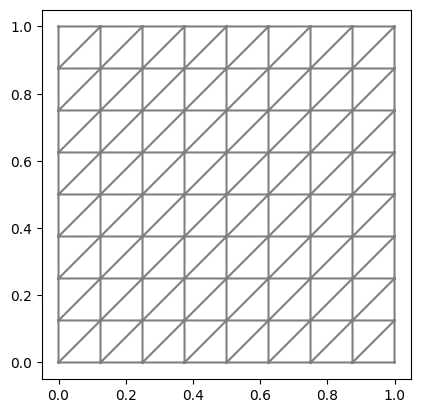

In [3]:
# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
plot(mesh)

## Defining function space

We define a finite element function space. The second argument 'P' specifies the type of element. The type of element here is $P$, implying the standard Lagrange family of elements. You may also use 'Lagrange' of 'CG' to specify this type of element. The argument can also be 'DG' for discontinuous Galerkin methods.

The third argument specifies the degree of the functions. Here, the functions are piecewise linear.

In [4]:
V = FunctionSpace(mesh, 'P', 1)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00941515 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.61714 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

## Specifying trial and test functions

In the Galerkin methods, the trial and test functions belong to the same function space.

In [5]:
u = TrialFunction(V)
v = TestFunction(V)

## Defining the variational problem

We need to specify the variational problem
$$\int_\Omega \boldsymbol{\nabla} u \cdot \boldsymbol{\nabla} v\ \mathrm{d}\boldsymbol{x} = \int_\Omega f(x) v\ \mathrm{d}\boldsymbol{x}.$$

In FEniCS, the variational form is specified by translating the mathematical expressions of the integrands into a [Unified Form Language (UFL)](http://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html), which is a domain-specific language based on Python and C++ syntax.

In [6]:
# Define variational problem
a = dot(grad(u), grad(v))*dx

f = Constant(-6.0)
L = f*v*dx

Here, `a` is the integrand on the left-hand side, `L` is the integrand on the right-hand side, `dx` denotes the measure. Since `Constant(-6.0)` defines a constant expression. Another way to write it is

```f = Expression('-6', degree=0)```

The  UFL is an integral part of FEniCS. An interesting feature of FEniCS is that it performs just-in-time (JIT) to translate the UFL into C++ code.

## Defining boundary conditions

The Poison equations do not have a unique solution  without proper boundary conditions. Next, we need to specify the boundary condition $u=u_D$ on $\partial \Omega$. We need to define an expression for $u_D$ and a function to indicate whether a point is on $\partial \Omega$.

For our specific model problem, $u_D = 1+x^2+2y^2$. The UFL specification uses a character string containing an expression in C++ syntax. In particular, $x$ and $y$ coordinates will be denoted as `x[0]` and `x[1]`. In 3D, the $z$ coordinate will be denoted as `x[2]`.

In [7]:
# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

We set the degree to 2 so that `u_D` may represent the exact quadratic solution to our test problem.

We also need to define an indicator to determine whether a point is on the Dirichlet boundary, and then specify the boundary condition.

In [8]:
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

At input, `on_boundary` specifies whether a node is on the physical boundary. We will show how to define more complicated boundary conditions in later examples.

## Forming and solving the linear system

We are now ready to solve the PDE using the solve function.

In [9]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7ac02186a034097be1a799e56117b4e7492f4ce6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_5]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.215621 seconds.

INFO:FFC:Compiler stage 2: C

We can also explicitly form the linear system and solve it instead.
```
A, b = assemble_system(a, L, bc)
solve(A, u.vector(), b)
```
This may be useful if we need to modify the matrix and vector, or export them to files.

## Post processing
We can then plot the solution and the mesh together for inspection:

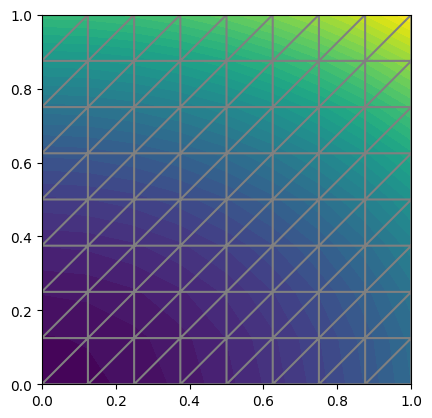

In [10]:
# Plot solution and mesh
plot(u)
plot(mesh)

We can also save the result into a VTK file for more advanced visualization and post-processing using [ParaView](https://www.paraview.org/) (recommended for FEniCS), [VisIt](https://visit.llnl.gov/), etc.

In [11]:
# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

In FEniCS, it is easy to perform some error analysis.

In [12]:
# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_76fc3cd9625812038c7471125b47cc4c7ae9ad4e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0117493 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 3.62951 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:------------------------------

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


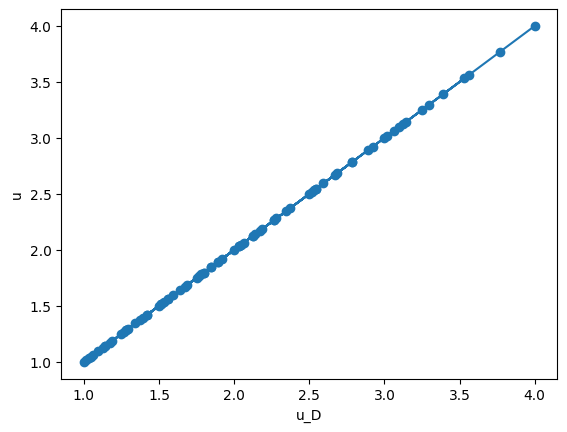

In [15]:
import matplotlib.pyplot as plt
plt.plot(vertex_values_u_D , vertex_values_u, '-o')
plt.xlabel('u_D')
plt.ylabel('u')
plt.show()

# 2. Learning about mesh generation through examples

In [18]:
# Copyright (C) 2014 Benjamin Kehlet
#
# This file is part of mshr.
#
# mshr is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# mshr is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with mshr. If not, see <http://www.gnu.org/licenses/>.
#
# https://bitbucket.org/fenics-project/mshr/src/master/demo/python/icecream.py
import dolfin
from mshr import *

# Define 3D geometry
sphere = Sphere(dolfin.Point(0, 0, 0), 0.5)
cone = Cylinder(dolfin.Point(0, 0, 0), dolfin.Point(0, 0, -1), .35, .1)

geometry = cone + sphere

# Geometry surfaces can be saved to off files
# which can be viewed by eg. MeshLab
meshing_domain = CSGCGALDomain3D(geometry)
meshing_domain.remove_degenerate_facets(1e-12)
meshing_domain.save("icecream.off")

# Test printing
dolfin.info("\nCompact output of 3D geometry:")
dolfin.info(geometry)
dolfin.info("\nVerbose output of 3D geometry:")
dolfin.info(geometry, True)

# Generate and plot mesh
m = generate_mesh(geometry, 16, "cgal")
m

# dolfin.plot(m, "3D mesh")

# # import matplotlib.pyplot as plt
# plt.show()



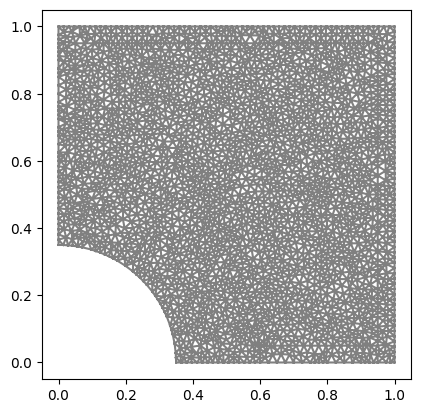

In [19]:
import dolfin
from mshr import *
# https://bitbucket.org/fenics-project/mshr/src/master/demo/python/materials.py
#dolfin.set_log_level(dolfin.TRACE)

# Define 2D geometry
domain = Rectangle(dolfin.Point(0., 0.), dolfin.Point(1., 1.)) - Circle(dolfin.Point(0.0, 0.0), .35)
domain.set_subdomain(1, Rectangle(dolfin.Point(.05, .05), dolfin.Point(.95, .95)))
domain.set_subdomain(2, Circle(dolfin.Point(0, 0), .45))
domain.set_subdomain(3, Circle(dolfin.Point(0,0), .6))

# Generate and plot mesh
mesh2d = generate_mesh(domain, 45)
dolfin.plot(mesh2d, "2D mesh")

# Convert subdomains to mesh function for plotting
mf = dolfin.MeshFunction("size_t", mesh2d, 2, mesh2d.domains())

In [20]:
from dolfin import *
from mshr import *
from math import pi, sin, cos, sqrt
# https://bitbucket.org/fenics-project/mshr/src/master/demo/python/deathstar.py
# Parameters
R = 1.02
r = 0.4
t = 10
x = R*cos(float(t) / 180 * pi)
y = 0
z = R*sin(t)

# Create geometry
s1 = Sphere(Point(0, 0, 0), 1)
s2 = Sphere(Point(x, y, z), r)
b1 = Box(Point(-2, -2, -0.03), Point(2, 2, 0.03))
geometry = s1 - s2 - b1

# Create mesh
mesh = generate_mesh(geometry, 32)
mesh

In [21]:
from mshr import *
from dolfin import *
# https://bitbucket.org/fenics-project/mshr/src/master/demo/python/propeller.py
# Set parameters
r = 0.125
R = 0.5
w = 0.3
h = 0.025
rotate_blades = True
include_tip = False
extra_rotation = True # only applied to inner mesh
resolution = 4

# Define geometries
sphere = Sphere(Point(0, 0, 0), 2*R)
geometry_inside = CSGGeometries.propeller(r, R, w, h, rotate_blades, include_tip)
geometry_outside = sphere - geometry_inside

# Generate meshes
mesh_inside = generate_mesh(geometry_inside, resolution)
mesh_outside = generate_mesh(geometry_outside, resolution)

# Rotate blades
if extra_rotation:
    print("Rotating blades...")
    c = mesh_inside.coordinates()
    for i, (x, y, z) in enumerate(c):

        # Compute distance to axis
        _r = sqrt(x**2 + y**2)

        # Compute rotation angle
        v = -2*max(0, _r - r)

        # Rotate blades
        xx = x; yy = y; zz = z;
        if x > 0 and abs(y) < 5*h:
            yy = cos(v)*y - sin(v)*z
            zz = sin(v)*y + cos(v)*z
        elif x < 0 and abs(y) < 5*h:
            yy = cos(v)*y + sin(v)*z
            zz = -sin(v)*y + cos(v)*z
        elif y > 0 and abs(x) < 5*h:
            xx = cos(v)*x + sin(v)*z
            zz = -sin(v)*x + cos(v)*z
        elif y < 0 and abs(x) < 5*h:
            xx = cos(v)*x - sin(v)*z
            zz = sin(v)*x + cos(v)*z

        # Store coordinates
        c[i][0] = xx
        c[i][1] = yy
        c[i][2] = zz

# Report size of meshes
print("Mesh of propeller inside:  %d cells" % mesh_inside.num_cells())
print("Mesh of propeller outside: %d cells" % mesh_outside.num_cells())

# Save meshes to file
File("propeller_inside.xml.gz") << mesh_inside
File("propeller_outside.xml.gz") << mesh_outside


Rotating blades...
Mesh of propeller inside:  18955 cells
Mesh of propeller outside: 25709 cells


In [22]:
mesh_inside

In [23]:
mesh_outside

In [25]:
import dolfin
from mshr import *
# https://bitbucket.org/fenics-project/mshr/src/master/demo/python/simple-csg-3D.py
# Define 3D geometry
box = Box(dolfin.Point(0, 0, 0), dolfin.Point(1, 1, 1))
sphere = Sphere(dolfin.Point(0, 0, 0), 0.3)
cylinder = Cylinder(dolfin.Point(0, 0, -1), dolfin.Point(0, 0, 1), 1., .5)

domain = box + cylinder - sphere

# Test printing
dolfin.info("\nCompact output of 3D geometry:")
dolfin.info(domain)
dolfin.info("\nVerbose output of 3D geometry:")
dolfin.info(domain, True)

# Creating a mesh generator object gives access to parameters of the
# meshing backend
generator = CSGCGALMeshGenerator3D()
generator.parameters["edge_size"] = 0.025
generator.parameters["facet_angle"] = 25.0
generator.parameters["facet_size"] = 0.05

# Invoke the mesh generator
mesh = generator.generate(CSGCGALDomain3D(domain))
mesh

In [27]:
from dolfin import *
import mshr
# https://bitbucket.org/fenics-project/mshr/src/master/demo/python/extrude.py
g2d = mshr.Circle(Point(0,0), 1.2) + mshr.Circle(Point(0, 1.2), 1.2)

# Any simple 2D geometry can be extruded to 3D
g3d = mshr.Extrude2D(g2d,
                     .2) # The z "thickness"

m = mshr.generate_mesh(g3d, 15)
m

Several other pre-made meshes available at: https://fenicsproject.org/pub/data/meshes/

# 3. 2D linear elasticity

This script sets up and solves a 2D linear elasticity problem using the FEniCS library. The key steps involve:

Mesh Generation: Creating a mesh for the domain.

Material Properties: Defining the elastic properties of the material.

Variational Formulation: Setting up the weak form of the elasticity equations.

Boundary Conditions: Applying appropriate boundary conditions.

Solving: Solving the resulting linear system to obtain the displacement field.

Postprocessing: Visualizing the results.

In [28]:
#https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/2D_elasticity.py.html
from dolfin import *

# Define the dimensions of the beam and the resolution of the mesh.
# Create a rectangular mesh representing the beam using RectangleMesh.
L = 25.
H = 1.
Nx = 250
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")
mesh

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00759721 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.193419 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

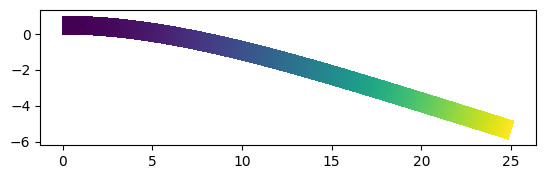

In [29]:
# Define the strain tensor, which is the symmetric part of the gradient of the displacement vector field v.
def eps(v):
    return sym(grad(v))

# Define the material properties: Young's modulus E and Poisson's ratio 𝜈
# Specify the model type. Here, "plane_stress" is used.
E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"

#Compute the Lame parameters 𝜇 and 𝜆 based on the material properties and adjust  𝜆 for the plane stress condition.
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
    lmbda = 2*mu*lmbda/(lmbda+2*mu)

# Define the stress tensor σ using the strain tensor and the Lame parameters.
# Define a constant body force f, representing gravity in the negative y-direction.
def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)
rho_g = 1e-3
f = Constant((0, -rho_g))


# Define the function space V for the displacement field using quadratic Lagrange elements.
# Define the trial function du and test function u_ for the variational formulation.
# Define the bilinear form a (stiffness matrix) and the linear form l (load vector).

V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)


#Define a function to identify the left boundary (x=0), where the beam is clamped.
#Apply a Dirichlet boundary condition bc to fix the displacement to zero at the left boundary.

u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx
def left(x, on_boundary):
    return near(x[0], 0)

bc = DirichletBC(V, Constant((0.,0.)), left)


# Define the solution function u for the displacement field.
# Solve the variational problem a == l with the boundary condition bc and store the solution in u.
u = Function(V, name="Displacement")
solve(a == l, u, bc)

#Plot the displacement field, scaled by a factor of 1000 for better visualization.
plot(1e3*u, mode="displacement")

In [30]:
print("Maximal deflection:", -u(L,H/2.)[1])
print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))

Maximal deflection: 0.005863753942800368
Beam theory deflection: 0.005859375


# 4. Orthotropic linear elasticity

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d41f70c3f1ac4d5a48d48c7706406a2cc5a5fc83

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 2
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              1
  Coefficients:                        '[f_302]'
  Unique elements:                     'Vector<2 x CG2(?,?)>, Vector<2 x R0(?,?)>, V
                                       ector<2 x CG1(?,?)>'
  Unique sub elements:                 'Vector<2 x CG2(?,?)>, Vector<2 x R0(?,?)>

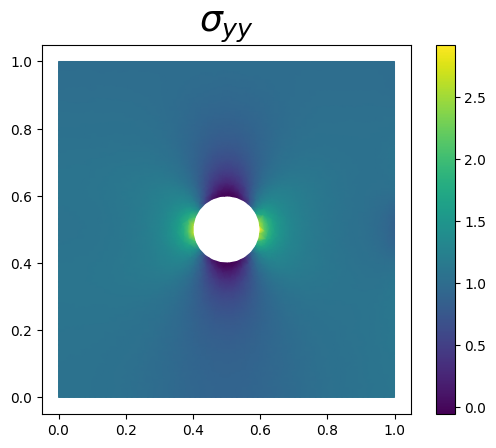

In [31]:
#https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/orthotropic_elasticity.py.html
from dolfin import *
from mshr import *

L, R = 1., 0.1
N = 50 # mesh density

circle_position = [0.5,0.5]
domain = Rectangle(Point(0.,0.), Point(L, L)) - Circle(Point(circle_position), R)
mesh = generate_mesh(domain, N)

Ex, Ey, nuxy, Gxy = 100., 10., 0.3, 5.
S = as_matrix([[1./Ex,-nuxy/Ex,0.],[-nuxy/Ex,1./Ey,0.],[0.,0.,1./Gxy]])
C = inv(S)

def eps(v):
    return sym(grad(v))
def strain2voigt(e):
    """e is a 2nd-order tensor, returns its Voigt vectorial representation"""
    return as_vector([e[0,0],e[1,1],2*e[0,1]])
def voigt2stress(s):
    """
    s is a stress-like vector (no 2 factor on last component)
    returns its tensorial representation
    """
    return as_tensor([[s[0], s[2]],
                     [s[2], s[1]]])
def sigma(v):
    return voigt2stress(dot(C, strain2voigt(eps(v))))

# SubDomain inheritance
class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], L) and on_boundary
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0) and on_boundary
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0) and on_boundary

# exterior facets MeshFunction
facets = MeshFunction("size_t", mesh, 1)
facets.set_all(0)
Top().mark(facets, 1)
Left().mark(facets, 2)
Bottom().mark(facets, 3)
ds = Measure('ds', subdomain_data=facets)

# Define function space
V = VectorFunctionSpace(mesh, 'Lagrange', 2)

# Define variational problem
du = TrialFunction(V)
u_ = TestFunction(V)
u = Function(V, name='Displacement')
a = inner(sigma(du), eps(u_))*dx

# uniform traction on top boundary
T = Constant((0, 1e-3))
l = dot(T, u_)*ds(1)

# symmetry boundary conditions
bc = [DirichletBC(V.sub(0), Constant(0.), facets, 2), #left
      DirichletBC(V.sub(1), Constant(0.), facets, 3)] #bottom

solve(a == l, u, bc)

import matplotlib.pyplot as plt
p = plot(sigma(u)[1, 1]/T[1], mode='color')
plt.colorbar(p)
plt.title(r"$\sigma_{yy}$",fontsize=26)
plt.show()

# 5. Axisymmetric formulation for elastic structures of revolution

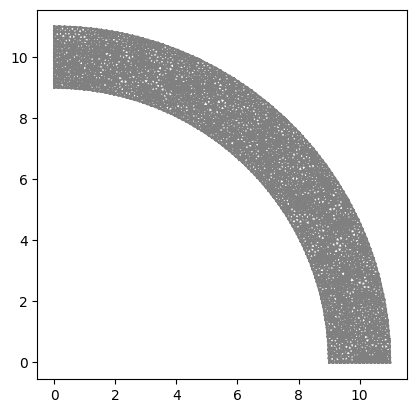

In [32]:
#https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/axisymmetric_elasticity.html
from __future__ import print_function
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt


Re = 11.
Ri = 9.
rect = Rectangle(Point(0., 0.), Point(Re, Re))
domain = Circle(Point(0., 0.), Re, 100) - Circle(Point(0., 0.), Ri, 100)
domain = domain - Rectangle(Point(0., -Re), Point(-Re, Re)) \
                - Rectangle(Point(0., 0.), Point(Re, -Re))

mesh = generate_mesh(domain, 40)
plot(mesh)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0) and on_boundary
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0) and on_boundary
class Outer(SubDomain):
    def inside(self, x, on_boundary):
        return near(sqrt(x[0]**2+x[1]**2), Re, 1e-1) and on_boundary

facets = MeshFunction("size_t", mesh, 1)
facets.set_all(0)
Bottom().mark(facets, 1)
Left().mark(facets, 2)
Outer().mark(facets, 3)
ds = Measure("ds", subdomain_data=facets)

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c8525360fbdecdbcc01968eee2839179a793966f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 4
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              1
  Coefficients:                        '[f_367]'
  Unique elements:                     'Vector<2 x CG2(?,?)>, R0(?,?), Vector<2 x CG
                                       1(?,?)>'
  Unique sub elements:                 'Vector<2 x CG2(?,?)>, R0(?,?), Vector<2 x CG
                                       1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  

Inwards radial displacement at (r=Re, theta=0): 0.0018375 (FE) 0.0018387 (Exact)
Inwards radial displacement at (r=Ri, theta=0): 0.0020879 (FE) 0.0020894 (Exact)


INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.115062 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:FFC:  Optimizing uflacs representation
INFO:FFC:  
INFO:FFC:Compiler stage 3 finished in 0.00626326 seconds.

INFO:FFC:Compiler stage 4: Generating code
INFO:FFC:---------------------------------
INFO:FFC:  Generating code for 0 finite_element(s)
INFO:FFC:  Generating code for 0 dofmap(s)
INFO:FFC:  Generating code for 0 coordinate_mapping(s)
INFO:FFC:  Generating code for integrals
INFO:FFC:  Generating code from ffc.uflacs representation
INFO:FFC:  Generating code for forms
INFO:FFC:  
INFO:FFC:Compiler stage 4 finished in 0.0208127 seconds.

INFO:FFC:Compiler stage 4.1 finished in 4.29153e-06 seconds.

INFO:FFC:Compiler stage 5: Formatting code
INFO:FFC:---------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 5 finished in 

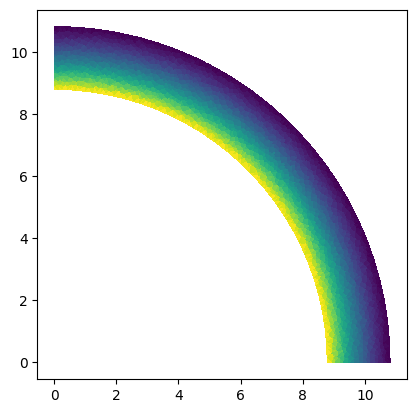

In [33]:
x = SpatialCoordinate(mesh)

def eps(v):
    return sym(as_tensor([[v[0].dx(0), 0, v[0].dx(1)],
                          [0, v[0]/x[0], 0],
                          [v[1].dx(0), 0, v[1].dx(1)]]))

E = Constant(1e5)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
def sigma(v):
    return lmbda*tr(eps(v))*Identity(3) + 2.0*mu*eps(v)
n = FacetNormal(mesh)
p = Constant(10.)

V = VectorFunctionSpace(mesh, 'CG', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*x[0]*dx
l = inner(-p*n, u_)*x[0]*ds(3)

u = Function(V, name="Displacement")
bcs = [DirichletBC(V.sub(1), Constant(0), facets, 1),
       DirichletBC(V.sub(0), Constant(0), facets, 2)]
solve(a == l, u, bcs)
print("Inwards radial displacement at (r=Re, theta=0): \
{:1.7f} (FE) {:1.7f} (Exact)".format(-u(Re, 0.)[0], float(Re**3/(Re**3-Ri**3)*((1-2*nu)*Re+(1+nu)*Ri**3/2/Re**2)*p/E)))
print("Inwards radial displacement at (r=Ri, theta=0): \
{:1.7f} (FE) {:1.7f} (Exact)".format(-u(Ri, 0.)[0], float(Re**3/(Re**3-Ri**3)*((1-2*nu)*Ri+(1+nu)*Ri/2)*p/E)))
plt.figure()
plot(100*u, mode="displacement")
plt.show()

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7806eb9d4db2dda177cc574d41bb3f929e5c017d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[Displacement]'
  Unique elements:           'Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?), 
                             CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.055881 seconds.

INFO:FFC:Compiler stage

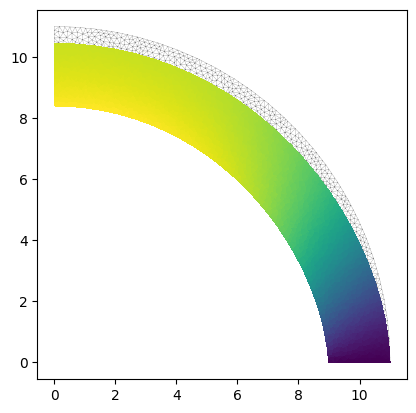

In [34]:
bcs = [DirichletBC(V, Constant((0., 0.)), facets, 1),
       DirichletBC(V.sub(0), Constant(0), facets, 2)]
solve(a == l, u, bcs)
plt.figure()
plot(mesh, linewidth=0.2)
plot(200*u, mode="displacement")
plt.show()

# 6. Heat equation

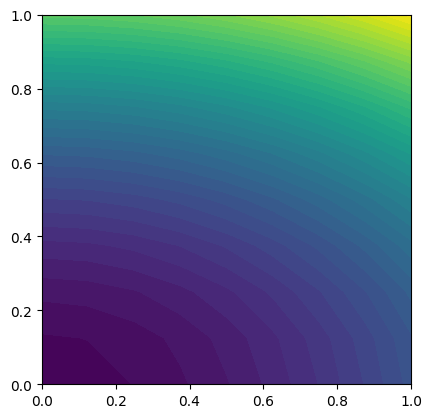

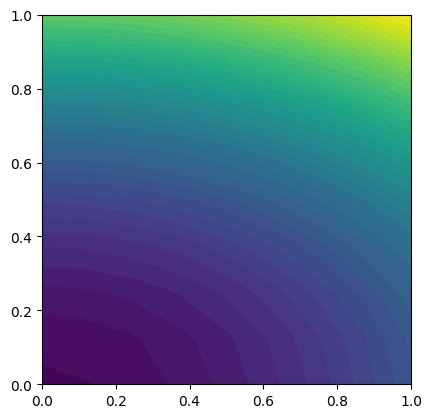

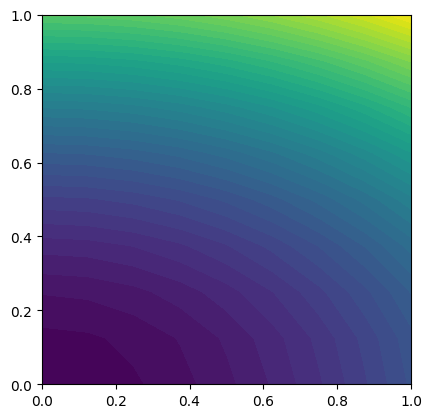

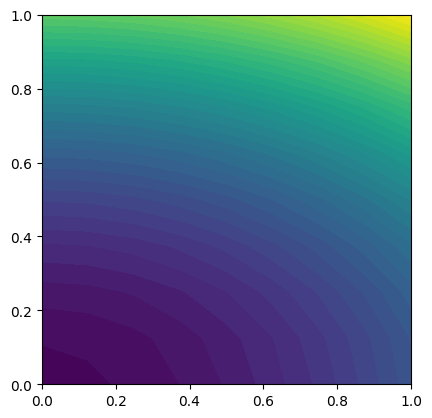

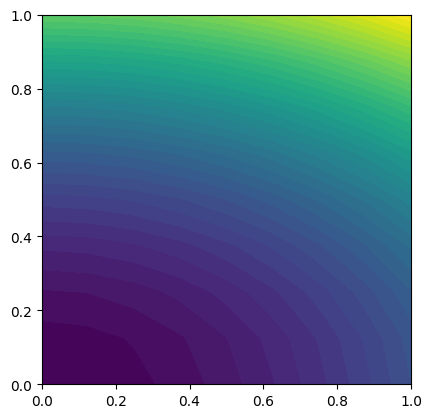

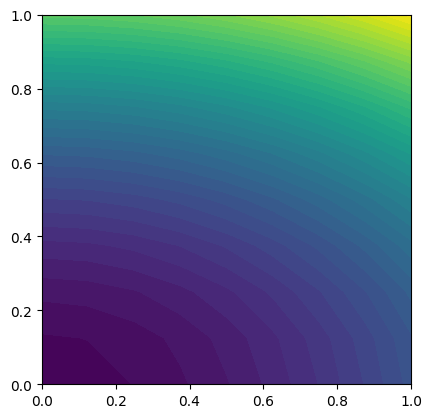

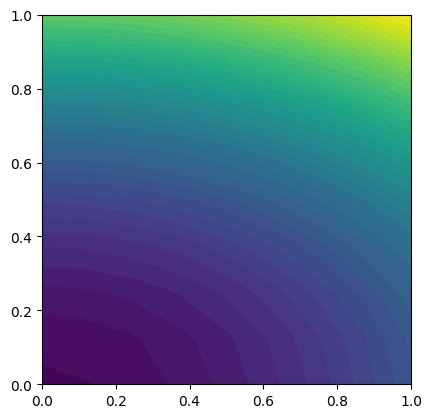

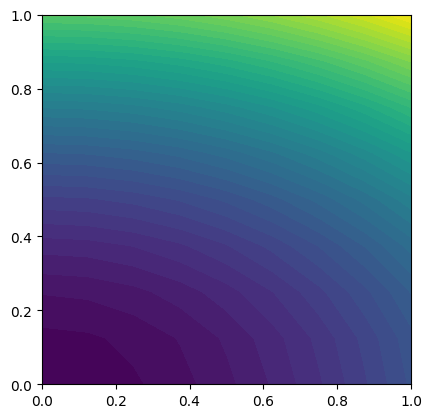

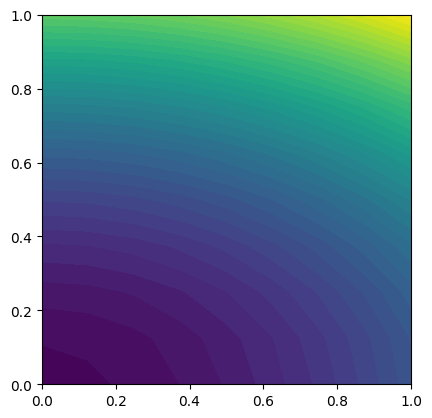

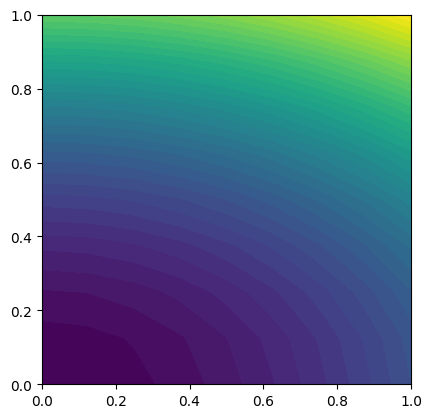

In [43]:
# https://fenicsproject.org/pub/tutorial/html/._ftut1006.html
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)
    plt.figure()
    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    # error = np.abs(u_e.vector().array() - u.vector().array()).max()
    # print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# 7. Thermo-elastic evolution problem

In [2]:
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# https://comet-fenics.readthedocs.io/en/latest/demo/thermoelasticity/thermoelasticity_transient.html
L = 1.
R = 0.1
N = 50  # mesh density

domain = Rectangle(Point(0., 0.), Point(L, L)) - Circle(Point(0., 0.), R, 100)
mesh = generate_mesh(domain, N)

T0 = Constant(293.)
DThole = Constant(10.)
E = 70e3
nu = 0.3
lmbda = Constant(E*nu/((1+nu)*(1-2*nu)))
mu = Constant(E/2/(1+nu))
rho = Constant(2700.)     # density
alpha = 2.31e-5  # thermal expansion coefficient
kappa = Constant(alpha*(2*mu + 3*lmbda))
cV = Constant(910e-6)*rho  # specific heat per unit volume at constant strain
k = Constant(237e-6)  # thermal conductivity

Vue = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
Vte = FiniteElement('CG', mesh.ufl_cell(), 1) # temperature finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vte]))

def inner_boundary(x, on_boundary):
    return near(x[0]**2+x[1]**2, R**2, 1e-3) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], 0) and on_boundary
def left(x, on_boundary):
    return near(x[0], 0) and on_boundary

bc1 = DirichletBC(V.sub(0).sub(1), Constant(0.), bottom)
bc2 = DirichletBC(V.sub(0).sub(0), Constant(0.), left)
bc3 = DirichletBC(V.sub(1), DThole, inner_boundary)
bcs = [bc1, bc2, bc3]

U_ = TestFunction(V)
(u_, Theta_) = split(U_)
dU = TrialFunction(V)
(du, dTheta) = split(dU)
Uold = Function(V)
(uold, Thetaold) = split(Uold)


def eps(v):
    return sym(grad(v))


def sigma(v, Theta):
    return (lmbda*tr(eps(v)) - kappa*Theta)*Identity(2) + 2*mu*eps(v)


dt = Constant(0.)
mech_form = inner(sigma(du, dTheta), eps(u_))*dx
therm_form = (cV*(dTheta-Thetaold)/dt*Theta_ +
              kappa*T0*tr(eps(du-uold))/dt*Theta_ +
              dot(k*grad(dTheta), grad(Theta_)))*dx
form = mech_form + therm_form
Nincr = 100
t = np.logspace(1, 4, Nincr+1)
Nx = 100
x = np.linspace(R, L, Nx)
T_res = np.zeros((Nx, Nincr+1))
U = Function(V)
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    dt.assign(dti)
    solve(lhs(form) == rhs(form), U, bcs)
    Uold.assign(U)
    T_res[:, i+1] = [U(xi, 0.)[2] for xi in x]
plt.figure()
plt.plot(x, T_res[:, 1::Nincr//10])
plt.xlabel("$x$-coordinate along $y=0$")
plt.ylabel("Temperature variation $\Theta$")
plt.legend(["$t={:.0f}$".format(ti) for ti in t[1::Nincr//10]], ncol=2)
plt.show()

Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8dcc7ff1a2a5155b4ca8e0d58559cea9e604269b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00511527 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.489469 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Increment 1


DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing eleme

Increment 2
Increment 3
Increment 4
Increment 5
Increment 6
Increment 7
Increment 8
Increment 9
Increment 10
Increment 11
Increment 12
Increment 13
Increment 14
Increment 15
Increment 16
Increment 17
Increment 18
Increment 19
Increment 20
Increment 21
Increment 22
Increment 23
Increment 24
Increment 25
Increment 26
Increment 27
Increment 28
Increment 29
Increment 30
Increment 31
Increment 32
Increment 33
Increment 34
Increment 35
Increment 36
Increment 37
Increment 38
Increment 39
Increment 40
Increment 41
Increment 42
Increment 43
Increment 44
Increment 45
Increment 46
Increment 47
Increment 48
Increment 49
Increment 50
Increment 51
Increment 52
Increment 53
Increment 54
Increment 55
Increment 56
Increment 57
Increment 58
Increment 59
Increment 60
Increment 61
Increment 62
Increment 63
Increment 64
Increment 65
Increment 66
Increment 67
Increment 68
Increment 69
Increment 70
Increment 71
Increment 72
Increment 73
Increment 74
Increment 75
Increment 76
Increment 77
Increment 78
Increme

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

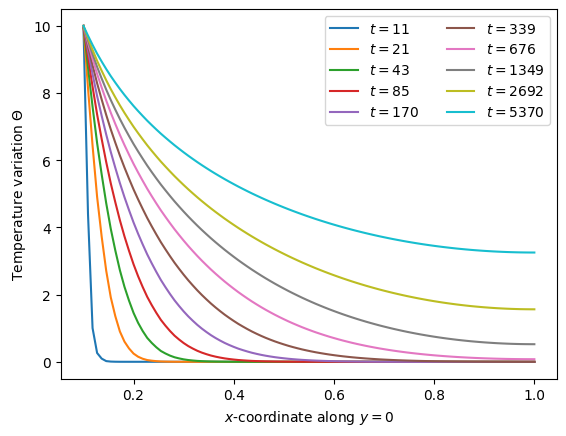

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(x, T_res[:, 1::Nincr//10])
plt.xlabel("$x$-coordinate along $y=0$")
plt.ylabel("Temperature variation $\Theta$")
plt.legend(["$t={:.0f}$".format(ti) for ti in t[1::Nincr//10]], ncol=2)
plt.show()

In [6]:
mesh

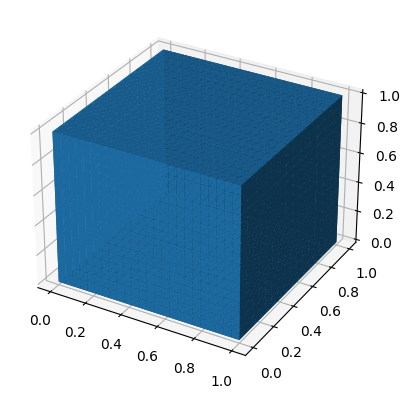

In [ ]:
# Extra code
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d
import dolfin.cpp as cpp
import ufl_legacy as ufl
import numpy as np

__all__ = ['plot']

_meshfunction_types = (cpp.mesh.MeshFunctionBool,
                       cpp.mesh.MeshFunctionInt,
                       cpp.mesh.MeshFunctionDouble,
                       cpp.mesh.MeshFunctionSizet)

def mplot_mesh(ax, mesh, **kwargs):
    tdim = mesh.topology().dim()
    gdim = mesh.geometry().dim()
    if gdim == 2 and tdim == 2:
        color = kwargs.pop("color", '#808080')
        return ax.triplot(mesh2triang(mesh), color=color, **kwargs)
    elif gdim == 3 and tdim == 3:
        bmesh = cpp.mesh.BoundaryMesh(mesh, "exterior", order=False)
        mplot_mesh(ax, bmesh, **kwargs)
    elif gdim == 3 and tdim == 2:
        xy = mesh.coordinates()
        return ax.plot_trisurf(*[xy[:, i] for i in range(gdim)],
                               triangles=mesh.cells(), **kwargs)
    elif tdim == 1:
        x = [mesh.coordinates()[:, i] for i in range(gdim)]
        if gdim == 1:
            x.append(np.zeros_like(x[0]))
            ax.set_yticks([])
        marker = kwargs.pop('marker', 'o')
        return ax.plot(*x, marker=marker, **kwargs)
    else:
        assert False, "this code should not be reached"


def _plot_matplotlib(obj):



    gdim = mesh.geometry().dim()
    if gdim == 3 :
        # Importing this toolkit has side effects enabling 3d support
        from mpl_toolkits.mplot3d import axes3d  # noqa
        # Enabling the 3d toolbox requires some additional arguments
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    else:
        ax = plt.gca()
        ax.set_aspect('equal')






    if isinstance(obj, cpp.function.Function):
        return mplot_function(ax, obj, **kwargs)
    elif isinstance(obj, cpp.function.Expression):
        return mplot_expression(ax, obj, mesh, **kwargs)
    elif isinstance(obj, cpp.mesh.Mesh):
        return mplot_mesh(ax, obj)
    elif isinstance(obj, cpp.fem.DirichletBC):
        return mplot_dirichletbc(ax, obj, **kwargs)
    elif isinstance(obj, _meshfunction_types):
        return mplot_meshfunction(ax, obj, **kwargs)
    else:
        raise AttributeError('Failed to plot %s' % type(obj))


_plot_matplotlib(u.function_space().mesh())

In [ ]:
u.function_space().mesh()